In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.datasets import make_blobs

# Add parent directory to path
import sys
import os
sys.path.append(os.path.split(os.path.abspath(os.getcwd()))[0])
from useful_tools import plot_boundary

from IPython.display import Image

# Introduksjon til beslutningstrær

Beslutningstrær er en intuitiv maskinlæringsteknikk som kan brukes til både klassifikasjon og regresjon.

## Klassifikasjon

Den lokale vindsurfeklubben har lyst til å bruke temperatur og vind til å finne ut når det er gode forhold for vindsurfing. Derfor har de samlet data om temperatur og vindhastiget i sommermånedene de siste ti årene, i tillegg til å ha testet om det faktisk var mulig å vindsurfe. Dataene kan du se i et scatterplot nedenfor. 

In [4]:
num_days = 30*10
wind = np.random.uniform(0, 13, num_days)
temp = np.random.uniform(10, 28, num_days)
classes = (np.greater(wind, 8) & np.greater(temp, 20)).astype(int)

df = pd.DataFrame(data={'good': classes, 'wind': wind, 'temp': temp}, index=range(len(classes)))
df.head()

,good,temp,wind
0,0,17.936842,11.270980
1,0,22.993863,7.530034
2,0,22.665882,3.487057
3,0,17.914561,11.449451
4,0,10.499413,10.697237


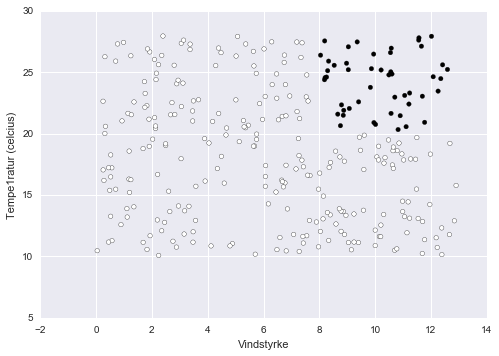

In [5]:
plt.scatter(df[['wind']], df[['temp']], c=classes)
plt.xlabel('Vindstyrke')
plt.ylabel('Tempe1ratur (celcius)')
plt.show()

Når vi ser på datane, ser det ut som at vi kan dele opp dataene våre ved `wind=8`. På den venstre siden ser vi dermed at det kun blir dager med dårlige forhold. 

Den høyre siden kan vi på nytt dele opp, men denne gangen vil det ha mer for seg å dele opp ved `temp=20` i stedet for å dele opp `wind` ytterligere.

Vi kan nå stoppe, siden vi ser at alle de svarte ligger innenfor et område, mens alle de hvite ligger innenfor et annet. 

Det er på mer eller mindre akkurat samme måten at trening av beslutningstrær fungerer: Vi begynner med hele planet. Så deler vi opp  langs en av aksene på den måten som gir størst mulig forbedring. Med det får vi altså to regioner.

Videre velger vi den regionen og den oppdelingen av regionen som gir best mulig forbedring akkurat som før. For hver splitt får vi to nye regioner. Alle regioner og 'alle' mulige splitter vurderes til hver splitt. Dette fortsetter helt til vi når et kriterium som er satt på forhånd. Dette kan for eksempel være å stoppe når ingen av splittene har flere enn et visst antall punkter. Klassifikatoren vi ender opp med i forrige eksempel ser slik ut:

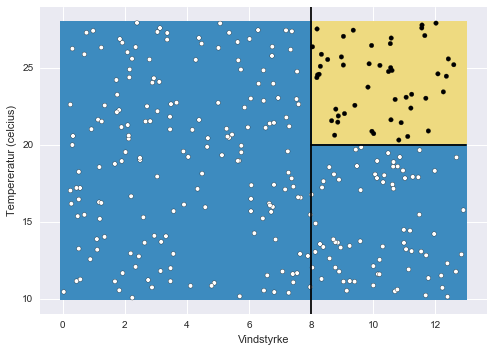

In [26]:
tree = DecisionTreeClassifier()
x = df[['wind', 'temp']]
y = df[['good']]

tree.fit(x, y)
plot_boundary(x, tree)

plt.scatter(wind, temp, c=classes)
plt.axvline(8, color='k')
plt.plot([8, 13], [20, 20], color='k')
plt.xlabel('Vindstyrke')
plt.ylabel('Tempereratur (celcius)')
plt.show()

Plottet ovenfor viser de to splittene som er gjort av beslutningstreet. Legg merke til at den andre splitten ikke deler hele planet i to, men bare den ene regionen. Det gule området er det området som vil bli klassifisert som gode forhold, og det blå som dårlige.

## Hvorfor kaller vi dette trær?

Figurene nedenfor demonstrerer tilpassing av et besluttningstre steg for steg

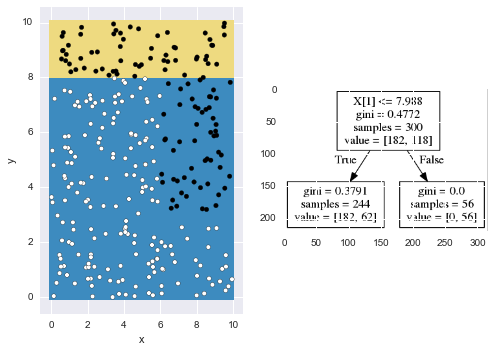

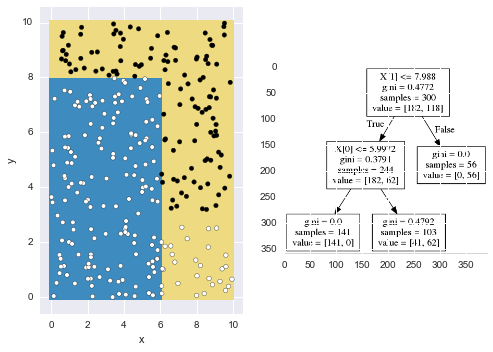

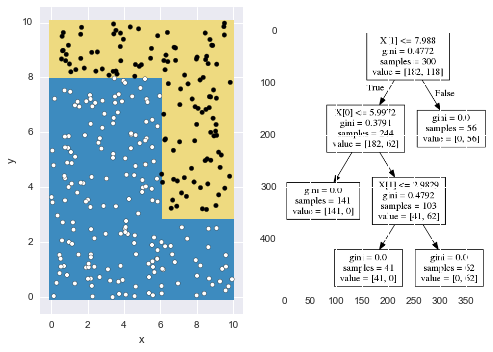

In [32]:
X = np.random.uniform(0, 10, (300, 2))
classes = np.greater(X[:,0], 6).astype(int)
classes = np.logical_and(np.greater(X[:,1], 3), classes)
classes = np.logical_or(np.greater(X[:,1], 8), classes)

for i in range(2, 5):
    tree = DecisionTreeClassifier(max_leaf_nodes=i)
    tree.fit(X, classes)
    export_graphviz(tree, out_file='tree_{}'.format(i))
    plt.subplot(121)
    plot_boundary(X, tree)
    plt.scatter(X[:,0], X[:,1], c=classes)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.subplot(122)
    plt.imshow(plt.imread('../trees/tree_{}.png'.format(i)))
    plt.show()

Figurene til høyre ovenfor er *beslutningstrær*. Beslutningstrærne er en type [flytskjema](https://en.wikipedia.org/wiki/Flowchart). Hver boks stiller et ja/nei-spørsmål om det nye punktet vi vil klassifisere. Vi følger pilene ut fra svaret på spørsmålet, helt til vi når slutten. Da har vi funnet det området som punktet hører til. Klassen punktet blir tildelt av klassifikatoren, bestemmes ut fra hvilken klasse det er flest av i treningssettet i akkurat dette området.

## Grenser
Trær ser ut til å fungere godt i de eksemplene vi har sett så langt, men hva skjer hvis grensene ikke er vinkelrette på aksene?

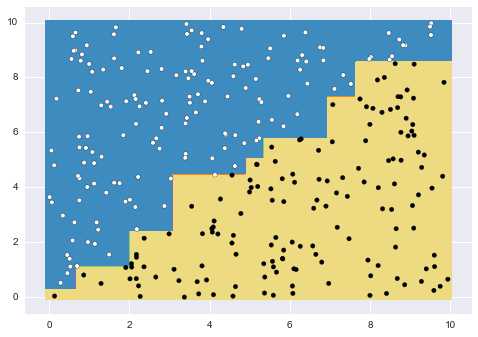

In [33]:
classes = np.greater(X[:,0], X[:,1])

tree_linear = DecisionTreeClassifier(min_samples_leaf=1)
tree_linear.fit(X, classes)

plot_boundary(X, tree_linear)
plt.scatter(X[:,0], X[:,1], c=classes)
plt.show()

Vi har her et tilfelle hvor den reele grensen er en rett strek som går over diagonalen. Siden trær kun kan trekke grenser som er parallelle med aksene, må denne linjen tilnærmes. En annen klassifikator kunne nok fungert bedre i dette tilfellet. 

## Overtilpassning 

Overtilpassing kan lett oppstå når vi bruker regresjonstrær. For eksempel hvis vi ikke er forsiktige når vi velger når vi skal stoppe. Hvis vi for eksempel tillater hvert område å ha bare ett datapunkt, kan vi risikere å få overtilpassning, slik som nedenfor.

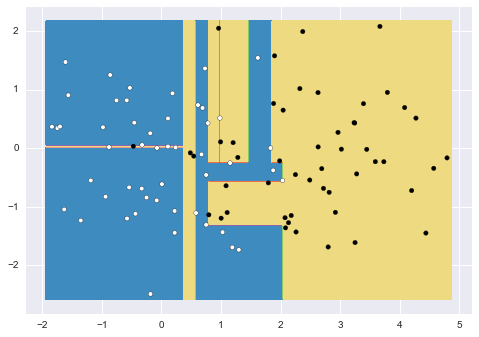

In [75]:
np.random.seed(100)
x, y = make_blobs(100, 2, [[0, 0], [2.5, 0]])

tree = DecisionTreeClassifier(min_samples_leaf=1)
tree.fit(x, y)

plot_boundary(x, tree)
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

## Regresjon

Å tilpasse er regresjonstre er på mange måter det samme som å tilpasse et klassifikasjonstre. Siden vi driver med regresjon i stedet for klassifikasjon, ønsker vi å minimere summen av feil i stedet for antall feilklassifiserte punkter. Tilpassningen skjer allikevel etter samme taktikk som tidligere. Vi gjør hele tiden den splitten som er best akkurat der og da.

Når det gjelder prediksjon, vil verdiene få gjennomsnittet av verdiene i regionen punktet tilhører.

Også for regresjon er det lett å overtilpasse, bare se på plottet nedenfor

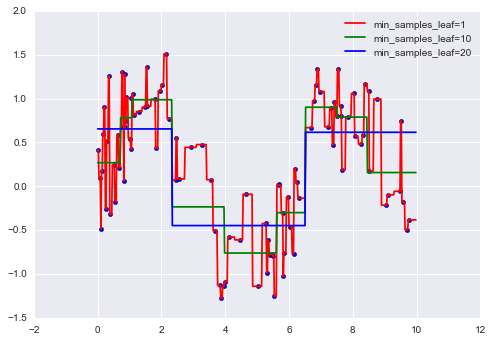

In [94]:
num_points = 100
x = np.random.uniform(0, 10, num_points).reshape(-1, 1)
y = np.sin(x).ravel() + np.random.normal(scale=0.4, size=num_points)

for n, color in zip([1, 10, 20], ['red', 'green', 'blue']):
    tree = DecisionTreeRegressor(min_samples_leaf=n)
    tree.fit(x, y)
    
    x_test = np.arange(0, 10, 0.02)[:, np.newaxis]
    y_test = tree.predict(x_test)
    plt.plot(x_test, y_test, color=color)
    
plt.scatter(x, y)
plt.legend(('min_samples_leaf=1', 'min_samples_leaf=10', 'min_samples_leaf=20'))
plt.show()

Som vi kan se, er det veldig lett å overtilpasse. Det kan derfor være lurt å justere parameterne til treet. For eksempel kan man sette begrensninger med dybden til treet (`max_depth`) eller kreve et større antall noder i hver løvnode (`min_samples_leaf`).